In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import pythTB_wan
import models as models
from pythtb import *

import matplotlib.pyplot as plt
import numpy as np

/Users/treycole/Codes/WanPy/top_obstruction


In [2]:
delta = 1
t = 1
t2 = -0.4

n_super_cell = 5
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}_n_occ={n_occ}'

In [3]:
save_name = f'Wan_frac_{model_str}_WFs'
sv_dir = 'data'
file_name = f"{sv_dir}/{save_name}.npy"

WFs = np.load(file_name, allow_pickle=True)
WFs_dict = WFs.item()
WFs_dict

{np.int64(24): <pythTB_wan.Wannier at 0x1075822c0>,
 np.int64(23): <pythTB_wan.Wannier at 0x1172452a0>,
 np.int64(22): <pythTB_wan.Wannier at 0x1172462f0>,
 np.int64(21): <pythTB_wan.Wannier at 0x117247340>,
 np.int64(20): <pythTB_wan.Wannier at 0x1172a83d0>,
 np.int64(19): <pythTB_wan.Wannier at 0x1172a9420>,
 np.int64(18): <pythTB_wan.Wannier at 0x1172aa470>,
 np.int64(17): <pythTB_wan.Wannier at 0x1172ab4c0>,
 np.int64(16): <pythTB_wan.Wannier at 0x122004550>,
 np.int64(15): <pythTB_wan.Wannier at 0x1220055a0>,
 np.int64(14): <pythTB_wan.Wannier at 0x1220065f0>,
 np.int64(13): <pythTB_wan.Wannier at 0x122007640>,
 np.int64(12): <pythTB_wan.Wannier at 0x1220646d0>,
 np.int64(11): <pythTB_wan.Wannier at 0x122065720>,
 np.int64(10): <pythTB_wan.Wannier at 0x122066770>,
 np.int64(9): <pythTB_wan.Wannier at 0x1220677c0>,
 np.int64(8): <pythTB_wan.Wannier at 0x1220cc850>,
 np.int64(7): <pythTB_wan.Wannier at 0x1220cd8a0>,
 np.int64(6): <pythTB_wan.Wannier at 0x1220ce8f0>,
 np.int64(5): <p

In [5]:
n_WFs = np.array(list(WFs_dict.keys()))
Wf_frac = n_WFs/n_occ # Wannier fraction
omega_til_lst = np.array([wf.omega_til for wf in list(WFs_dict.values())]) # omega tildes
omega_i_lst = np.array([wf.omega_i for wf in list(WFs_dict.values())]) # omega_i s
avg_omega_til = omega_til_lst / n_WFs # normalize spread 
avg_omega_i = omega_i_lst / n_WFs # normalize spread

print(f"# occupied bands: {n_occ}")

# occupied bands: 25


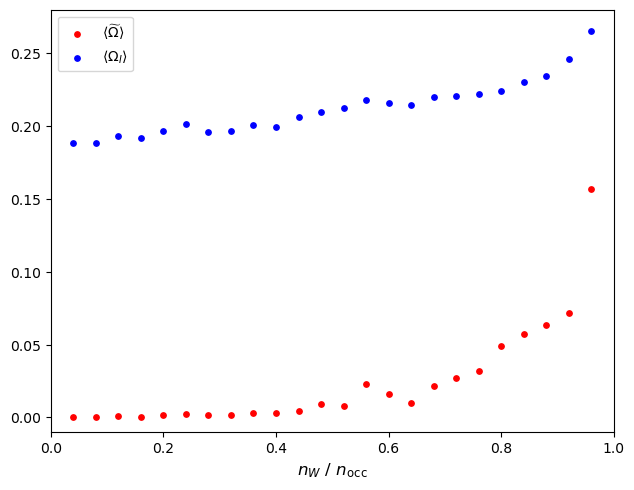

In [34]:
plt.scatter(Wf_frac, avg_omega_til, c='r', s=15, label=r'$\langle \widetilde{\Omega} \rangle$') # / # Wannier functions
plt.scatter(Wf_frac, avg_omega_i, c='b', s=15, label=r'$\langle \Omega_I \rangle$')

# plt.ylabel(r'$\langle \widetilde{\Omega} \rangle$', size=12)
plt.xlabel(r'$n_{W}\ /\ n_{\rm occ}$', size=12)
# plt.title(r"C=-1.0 $\Delta$ = 1 $t_0=0.4$ $t'=0.5$")
plt.ylim(-0.01, .28)
plt.xlim(0, 1.0)
plt.legend()

plt.subplots_adjust(top=0.98, left=0.1, bottom=0.1, right=0.98)

save_name = f'Delta={delta}_t={t}_n_occ={n_occ}'
plt.savefig(f'images/Wan_frac_{save_name}.png', dpi=700)

In [23]:
def plot_centers(
        WF, omit_sites=None, 
        section_home_cell=True, color_home_cell=True, translate_centers=False,
        title=None, save_name=None, show=False, legend=False, pmx=4, pmy=4,
        kwargs_centers={'s': 80, 'marker': '*', 'c': 'g'},
        kwargs_omit={'s': 50, 'marker': 'x', 'c':'k'},
        kwargs_lat={'s':10, 'marker': 'o', 'c':'k'}, fig=None, ax=None
    ):
    lat_vecs = WF.Lattice.get_lat_vecs()
    orbs = WF.Lattice.get_orb(Cartesian=False)
    w0 = WF.WFs
    centers = WF.centers

    nx, ny = w0.shape[0], w0.shape[1]

    supercell = [(i,j) for i in range(-int((nx-nx%2)/2), int((nx-nx%2)/2)) 
                for j in range(-int((ny-ny%2)/2), int((ny-ny%2)/2))]
    
    # Initialize arrays to store positions and weights
    positions = {
        'all': {'xs': [], 'ys': []},
        'centers': {'xs': [[] for i in range(centers.shape[0])], 'ys':[[] for i in range(centers.shape[0])]},
        'home even': {'xs': [], 'ys': []},
        'home odd': {'xs': [], 'ys': []},
        'omit': {'xs': [], 'ys': []},
        'even': {'xs': [], 'ys': []},
        'odd': {'xs': [], 'ys': []}
    }

    for tx, ty in supercell:
        for i, orb in enumerate(orbs):
            # Extract relevant parameters
            pos = orb[0] * lat_vecs[0] + tx * lat_vecs[0] + orb[1] * lat_vecs[1] + ty * lat_vecs[1]
            if translate_centers:
                for j in range(centers.shape[0]):
                    center = centers[j] + tx * lat_vecs[0] + ty * lat_vecs[1]
                    positions['centers']['xs'][j].append(center[0])
                    positions['centers']['ys'][j].append(center[1])

            # rel_pos = pos - center
            x, y = pos[0], pos[1]

            # Store values in 'all'
            positions['all']['xs'].append(x)
            positions['all']['ys'].append(y)

            # Handle omit site if applicable
            if omit_sites is not None and i in omit_sites:
                positions['omit']['xs'].append(x)
                positions['omit']['ys'].append(y)
            # Separate even and odd index sites
            if i % 2 == 0:
                positions['even']['xs'].append(x)
                positions['even']['ys'].append(y)
                if tx == ty == 0:
                    positions['home even']['xs'].append(x)
                    positions['home even']['ys'].append(y)
            else:
                positions['odd']['xs'].append(x)
                positions['odd']['ys'].append(y)
                if tx == ty == 0:
                    positions['home odd']['xs'].append(x)
                    positions['home odd']['ys'].append(y)


    # Convert lists to numpy arrays (batch processing for cleanliness)
    for key, data in positions.items():
        for sub_key in data:
            positions[key][sub_key] = np.array(data[sub_key])

    # All positions
    xs = positions['all']['xs']
    ys = positions['all']['ys']

    # home cell site positions
    xs_ev_home = positions['home even']['xs']
    ys_ev_home = positions['home even']['ys']
    xs_odd_home = positions['home odd']['xs']
    ys_odd_home = positions['home odd']['ys']

    # omitted site positions
    xs_omit = positions['omit']['xs']
    ys_omit = positions['omit']['ys']

    # sublattice positions
    xs_ev = positions['even']['xs']
    ys_ev = positions['even']['ys']
    xs_odd = positions['odd']['xs']
    ys_odd = positions['odd']['ys']

      
    if fig is None:
        fig, ax = plt.subplots()

    # Weight plot

    if omit_sites is not None :
        ax.scatter(xs_omit, ys_omit, **kwargs_omit)

    if color_home_cell:
        # Zip the home cell coordinates into tuples
        home_ev_coords = set(zip(xs_ev_home, ys_ev_home))

        # Filter even sites: Keep (x, y) pairs that are not in home_coordinates
        out_even = [(x, y) for x, y in zip(xs_ev, ys_ev) if (x, y) not in home_ev_coords]
        if out_even:
            xs_ev_out, ys_ev_out = zip(*out_even)
        else:
            xs_ev_out, ys_ev_out = [], []  # In case no points are left

        # Zip the home cell coordinates into tuples
        home_odd_coords = set(zip(xs_odd_home, ys_odd_home))

        # Filter even sites: Keep (x, y) pairs that are not in home_coordinates
        out_odd = [(x, y) for x, y in zip(xs_odd, ys_odd) if (x, y) not in home_odd_coords]
        if out_even:
            xs_odd_out, ys_odd_out = zip(*out_odd)
        else:
            xs_odd_out, ys_odd_out = [], []  # In case no points are left
        
        if 'c' in kwargs_lat.keys():
            kwargs_lat.pop('c')
        ax.scatter(xs_ev_out, ys_ev_out, zorder=2, c='k', **kwargs_lat)
        ax.scatter(xs_odd_out, ys_odd_out, zorder=2, facecolors='none', edgecolors='k', **kwargs_lat)

        ax.scatter(xs_ev_home, ys_ev_home, zorder=2, c='b', **kwargs_lat)
        ax.scatter(xs_odd_home, ys_odd_home,zorder=2, facecolors='none', edgecolors='r', **kwargs_lat)
    
    else:
        ax.scatter(xs_ev, ys_ev, zorder=2, **kwargs_lat)
        ax.scatter(xs_odd, ys_odd, zorder=2, facecolors='none', edgecolors='k', **kwargs_lat)

    # draw lines sectioning out home supercell
    if section_home_cell:
        c1 = np.array([0,0])
        c2 = c1 + lat_vecs[0]
        c3 = c1 + lat_vecs[1]
        c4 = c1 + lat_vecs[0] + lat_vecs[1]

        ax.plot([c1[0], c2[0]], [c1[1], c2[1]], c='k', ls='--', lw=1)
        ax.plot([c1[0], c3[0]], [c1[1], c3[1]], c='k', ls='--', lw=1)
        ax.plot([c3[0], c4[0]], [c3[1], c4[1]], c='k', ls='--', lw=1)
        ax.plot([c2[0], c4[0]], [c2[1], c4[1]], c='k', ls='--', lw=1)

    # scatter centers
    for i in range(centers.shape[0]):
        if translate_centers:
            x = positions['centers']['xs'][i]
            y = positions['centers']['ys'][i]
            # label = fr"Center $\mathbf{{r}}^{{({i})}}_c = ({center[0]: .3f}, {center[1]: .3f})$"
            if i ==0:
                label = "Wannier centers"
            else:
                label=None
            ax.scatter(
                x, y, zorder=1, label=label, **kwargs_centers)
        else:
            center = centers[i]
            label = "Wannier centers"
            ax.scatter(
                center[0], center[1], zorder=1, label=label, **kwargs_centers)

    if legend:
        ax.legend(loc='upper right')
    
    center_sc = (1/2) * (lat_vecs[0] + lat_vecs[1])
    ax.set_xlim(center_sc[0] - pmx, center_sc[0] + pmx)
    ax.set_ylim(center_sc[1] - pmy, center_sc[1] + pmy)

    ax.set_title(title)

    # Saving
    if save_name is not None:
        plt.savefig(f'Wan_wt_{save_name}.png')

    if show:
        plt.show()
        
    return fig, ax

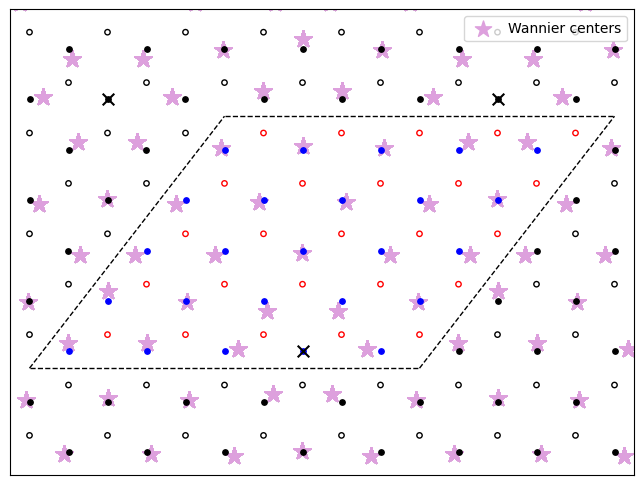

In [29]:
n_wfs = 24
Wf = WFs_dict[n_wfs] # 17/25 Wannier functions
trial_wfs = Wf.trial_wfs
delta_sites = np.sort(np.array([int(np.where(trial_wfs[i]!=0)[0][0]) for i in range(trial_wfs.shape[0])]))
omit_sites = np.setdiff1d(low_E_sites, delta_sites)

title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

kwargs_centers = {'s': 150, 'marker':'*', 'c':'plum', 'alpha':1} 
kwargs_omit = {'s': 70, 'marker':'x', 'c':'k', 'zorder':3} 
kwargs_lat = {'s': 15, 'marker':'o', 'c':'k'} 

fig, ax = plot_centers(
    Wf, title=title, omit_sites=omit_sites, section_home_cell=True, 
    color_home_cell=True, translate_centers=True, kwargs_centers=kwargs_centers, 
    kwargs_lat=kwargs_lat, kwargs_omit=kwargs_omit, pmx=4, pmy=4, legend=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

save_name = f'Wan_centers_{model_str}_nWfs={n_wfs}'
sv_dir = 'images'
file_name = f"{sv_dir}/{save_name}.png"

plt.subplots_adjust(top=0.98, left=0.01, bottom=0.01, right=0.985)

plt.savefig(file_name, dpi=700)

Shift supercell origin, figure out centers of divergences